In [46]:
from math import *
from numpy import sign
from tqdm import *
import numpy as np
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib
import matplotlib.cbook 
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as rand

from matplotlib import rc

%matplotlib inline  



In [37]:
mylumi=37*1000
mycut='MEt > 800 & nj>= 2 & pt1 >100 & pt2>80 & pt4 > 50 & dphi < 0.4'

def get_sig(mZ, rinv, b, cut=mycut, lumi=mylumi, folder='../gen/tChannelTotalFinal/'):
    str1='{:d}'.format(mZ)
    if rinv >= .1 and rinv <=.9:
        str2='{:1.1f}'.format(rinv)  
    elif rinv != 1:
        str2='{:1.2f}'.format(rinv)
    else:
        str2='1.0'
    strevt='tchannel_total_M' + str1 + '_rinv' + str2 + '.evt'
    strmeta='tchannel_total_M' + str1 + '_rinv' + str2 + '.meta'
    data_evt = pd.read_csv(folder+strevt, header=0, delimiter=',', skipinitialspace=True)
    data_meta = pd.read_csv(folder+strmeta, header=0, delimiter=',', skipinitialspace=True)
    data_evt = data_evt.query(cut)
    cxn = data_meta['cxn']*1
    scale=cxn*lumi/data_meta['nevt']
    result, _ =np.histogram(np.asarray(data_evt['MEt']), bins=b,
                            weights=np.repeat(scale[0],len(data_evt.index)))
    # Apply a mask
    return np.append(result, result[-1])


mybins=10**np.linspace(log10(100),log10(8000),11) # MEt bins

def readfile(name, folder='ntuple_Tchannel/', lumi=mylumi, cxn=None):
    data = pd.read_csv(folder+name+'.evt', header=0, delimiter=',', skipinitialspace=True)
    data.meta = pd.read_csv(folder+name+'.meta', header=0, delimiter=',', skipinitialspace=True)
    if 'weight' in data.columns:
        data['weight'] *= (data.meta['cxn']*lumi/data.meta['sum_weight'])[0]
    else:
        data['weight'] = (data.meta['cxn']*lumi / data.meta['nevt'])[0]  
    if cxn is not None:
        data['weight'] = (cxn*lumi / data.meta['nevt'])[0]  
    return data

bkg_files = ['bkg_ttbar_dilep_0',  'bkg_ttbar_semilep_0',  'bkg_Wj_0',  'bkg_Zj_0']

bkg_files = ['bkg_Wj_0',  'bkg_Zj_0']

bkg_files = [ readfile(f,folder='../analysis/BkgNtuplesWithMT/') for f in bkg_files ]

def get_bkg(b, cut=mycut, lumi=mylumi):
    bw = np.array(b[1:]-b[:-1])
    bc = np.sqrt(b[1:]*b[:-1])
    bkg_select=[ f.query(cut) for f in bkg_files ]
    result = np.array( [ np.histogram( np.asarray(f['MEt']), bins=b,
                            weights=f['weight'] )[0] for f in bkg_select ] )
    result = np.sum(result, axis=0)
    return np.append(result, result[-1])



In [39]:
rinv=np.array([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
#masses=[500,1000,2000,3000,4000,5000,7000,10000,20000,50000,100000] #[10000] #np.arange(300,3100,100)
masses=[500,1000,2000,3000,4000]

#basecut='MEt > 1000 & '
cutlist=[]

# scan over different cuts

# for MEtcut in [0, 100, 200, 400, 600, 800, 1000, 1200]:
#     for pt2cut in [100, 120, 140]:
#         for HTcut in [0, 400]:
#             for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
#                 c1 = 'MEt > ' + str(MEtcut) + ' & '
#                 c2 = 'pt2 > ' + str(pt2cut) + ' & '
#                 c3 = 'pt1 + pt2 + pt3 + pt4 > ' + str(HTcut) + ' & '
#                 cutlist = cutlist + [ c1 + c2 + c3 + dphicut ]

for MEtcut in [800, 1000, 1200]:
    for pt2cut in [100, 120, 140, 180, 240]:
        for HTcut in [0, 400]:
            for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
                c1 = 'MEt > ' + str(MEtcut) + ' & '
                c2 = 'pt2 > ' + str(pt2cut) + ' & '
                c3 = 'pt1 + pt2 + pt3 + pt4 > ' + str(HTcut) + ' & '
                cutlist = cutlist + [ c1 + c2 + c3 + dphicut ]


result=np.zeros([len(rinv),len(masses)])
cutindex=np.zeros([len(rinv),len(masses)],dtype=int)

#get all the bkg first
bkg_list=[ get_bkg(mybins, cut=c) for c in cutlist ]

In [44]:
def soverb(s,b):
    return s/np.sqrt(s+b)

In [45]:
for im,m in tqdm(enumerate(masses)):
    for ir,r in enumerate(rinv[1:]):
        tempresult=np.array([ soverb(np.sum(get_sig(m,r, mybins, cut)),np.sum(bkg_list[i])) for i,cut in enumerate(cutlist)])
        print("{:1.2f}, {:d}, {:1.3f}".format(r,m,np.amax(tempresult)))
        result[ir, im]=np.amax(tempresult)
        cutindex[ir, im]=np.amax(tempresult)
        print("optimal cut: ",cutlist[cutindex[ir,im]])



0it [00:00, ?it/s]

0.10, 500, 0.784
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.20, 500, 1.537
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi > 0.4')
0.30, 500, 2.156
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.40, 500, 1.495
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi > 0.4')
0.50, 500, 5.891
('optimal cut: ', 'MEt > 800 & pt2 > 120 & dphi > 0.4')
0.60, 500, 5.212
('optimal cut: ', 'MEt > 800 & pt2 > 120 & dphi > 0.4')
0.70, 500, 6.151
('optimal cut: ', 'MEt > 800 & pt2 > 120 & dphi < 0.4')
0.80, 500, 9.343
('optimal cut: ', 'MEt > 800 & pt2 > 140 & dphi > 0.4')
0.90, 500, 7.065
('optimal cut: ', 'MEt > 800 & pt2 > 120 & dphi > 0.4')


1it [01:03, 63.84s/it]

1.00, 500, 11.494
('optimal cut: ', 'MEt > 800 & pt2 > 140 & dphi > 0.4')
0.10, 1000, 0.366
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.20, 1000, 0.469
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.30, 1000, 1.102
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi > 0.4')
0.40, 1000, 1.339
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi > 0.4')
0.50, 1000, 1.618
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi > 0.4')
0.60, 1000, 1.915
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi > 0.4')
0.70, 1000, 2.507
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.80, 1000, 4.693
('optimal cut: ', 'MEt > 800 & pt2 > 120 & dphi < 0.4')
0.90, 1000, 5.765
('optimal cut: ', 'MEt > 800 & pt2 > 120 & dphi > 0.4')


2it [01:42, 56.20s/it]

1.00, 1000, 9.922
('optimal cut: ', 'MEt > 800 & pt2 > 140 & dphi > 0.4')
0.10, 2000, 0.087
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.20, 2000, 0.134
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.30, 2000, 0.195
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.40, 2000, 0.267
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')
0.50, 2000, 0.298
('optimal cut: ', 'MEt > 800 & pt2 > 100 & dphi < 0.4')


KeyboardInterrupt: 

In [38]:
cut = 'MEt > 1000 & dphi > .4 & pt1 > 250'

s = np.sum(get_sig(10000,.3, mybins, cut))
b = np.sum(get_bkg(mybins, cut))
           
print s, b
print s/b, s/np.sqrt(b), s/np.sqrt(s+b)

0.00106705412157 168.962793474
6.31532007507e-06 8.20901231276e-05 8.20898639162e-05


In [76]:
get_sig(1000,.3,mybins,cut='MEt > 0')

array([ 4393.21744869,  2884.95887635,  1660.5346782 ,   678.50917918,
         125.34291707,    10.35891877,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ])

[ -562.64870275   361.25432303   575.04213427   999.49973788   880.12114143
  1016.45005753  1045.41825667  1160.18431481  1304.82058836  1509.03279654
  1502.94414221  2500.        ]
[    0.             0.           575.04213427   999.49973788   880.12114143
  1016.45005753  1045.41825667  1160.18431481  1304.82058836  1509.03279654
  1502.94414221  2500.        ]


/group/hepheno/heptools/anaconda3/envs/venv_py27/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


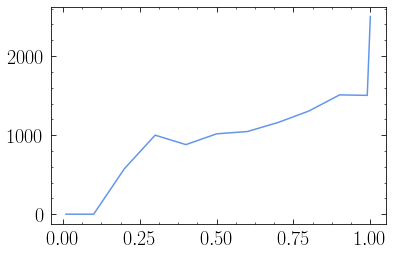

In [51]:
from scipy.optimize import fsolve

mass_limit=np.zeros(len(rinv))
for i,r in enumerate(rinv):
    mymass = np.insert(masses,0,0)
    masslist = np.insert(result[i],0,0)    
    mass_limit[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist), 2500)[0]

final_limit=mass_limit
print(mass_limit)


final_limit[0]=0
final_limit[1]=0
cutoff = final_limit/sqrt(.1)
plt.plot(rinv,final_limit)
print(final_limit)

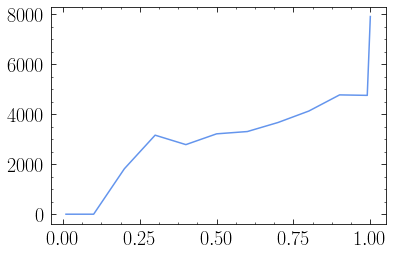

In [52]:
plt.plot(rinv,cutoff)

In [59]:
df = pd.read_csv("../gen/tChannelTotalFinal/tchannel_total_M500_rinv1.0.evt", header=0, delimiter=',', skipinitialspace=True)

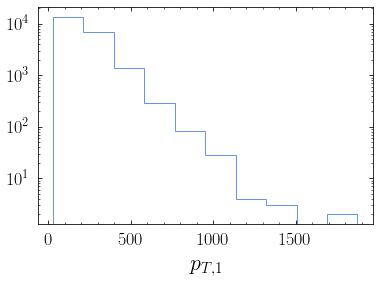

In [65]:
plt.hist(df['pt1'], histtype='step')
plt.yscale("log")
plt.xlabel("$p_{T,1}$")

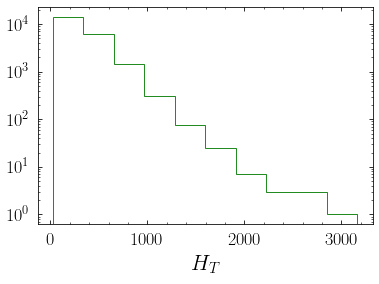

In [69]:
plt.hist(df['pt1']+df['pt2']+df['pt3']+df['pt4'], histtype='step', color='forestgreen')
plt.yscale("log")
plt.xlabel("$H_{T}$")